# Advanced Lane Finding ---- Experiments

## The Project


The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called output_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

# Code Tryouts

In [80]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle


from IPython.display import Image
from ipywidgets import interact, interactive, fixed

In [81]:
# Custom helper functions 
def display(image_list, color='gray'):
    """ Helper function to print out the images 
    """
    plt.figure(figsize=(30,15))
    columns = 4
    if(color != 'gray'):
        for i, image in enumerate(image_list):
            plt.subplot(len(image_list) / columns + 1, columns, i + 1)
            plt.imshow(image)
    else:
        for i, image in enumerate(image_list):
            plt.subplot(len(image_list) / columns + 1, columns, i + 1)
            plt.imshow(image, cmap='gray')

def display_image(image, color='gray'):
    """ Helper function to print out the images 
    """
    plt.figure(figsize=(30,15))

    if(color != 'gray'):
            plt.imshow(image)
    else:
            plt.imshow(image, cmap='gray')
            
def undistort_images(images_list, mtx, dist, dir_name = 'calibration_wide/', todo = 'save'):
    undistort_list = []
    for idx, fname in enumerate(images_list):
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        if(todo == 'save'):
            lwords = fname.split('/')
            snip = lwords[-1].split('.jpg')
            fname = dir_name + snip[0] + '_undistorted.jpg'
            cv2.imwrite(fname,dst)
    return undistort_list

def convert_hls(rgb_img):
    return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)

##  Find and draw chessboard corners

In [82]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
       # cv2.imshow('img', img)


## Computing calibration matrix and distortion coefficients

In [83]:
test_image = images[0]
test_image = cv2.imread(test_image)
img_size = (img.shape[1], img.shape[0])
ret, matx, disto, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = matx
dist_pickle["dist"] = disto
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )

In [84]:
# Read in the saved camera matrix and dist coeffs
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    fname = 'calibration_wide/' + str(idx) + '_undistorted.jpg'
    cv2.imwrite(fname,dst)

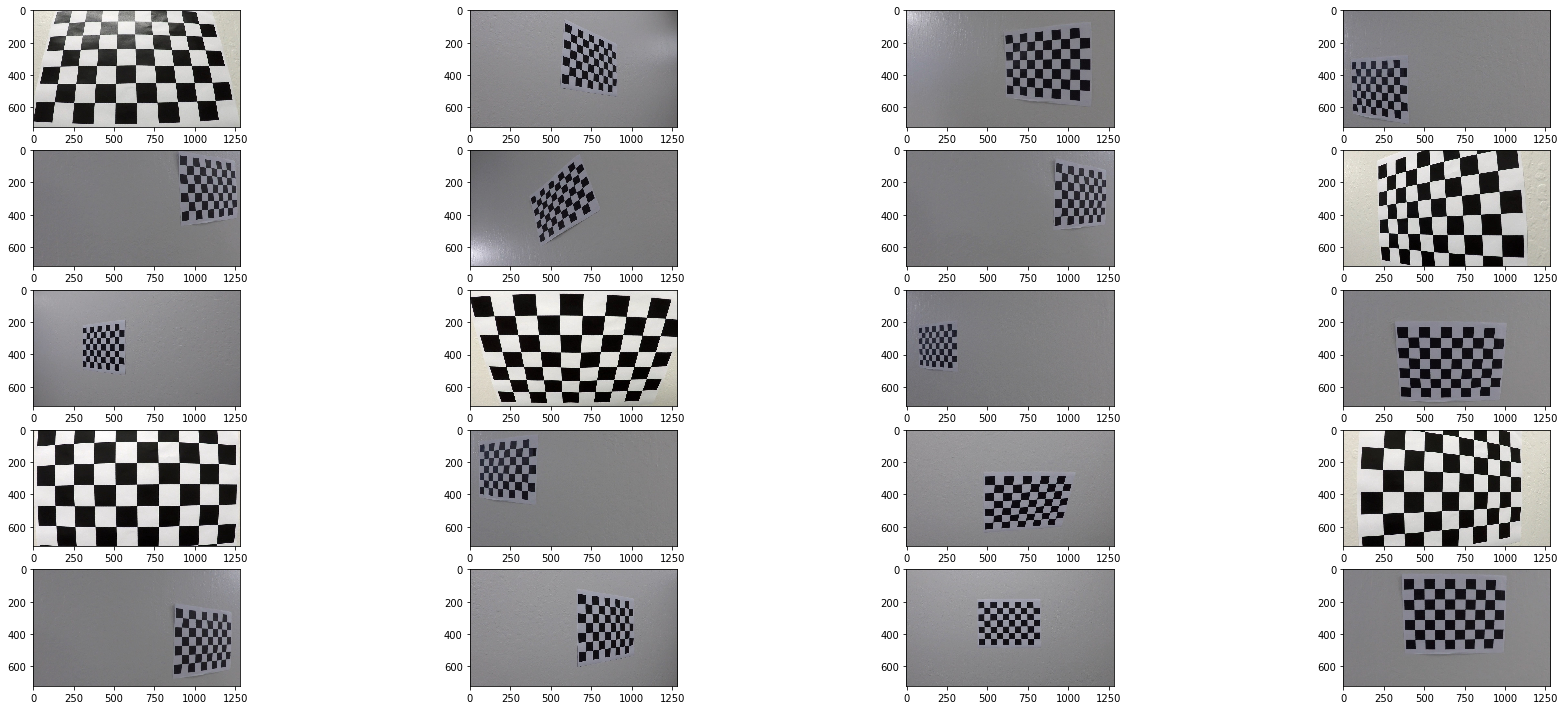

In [85]:
# Display a list of distorted images
dist_images = [mpimg.imread(file) for file in images]
display(dist_images,'rgb')

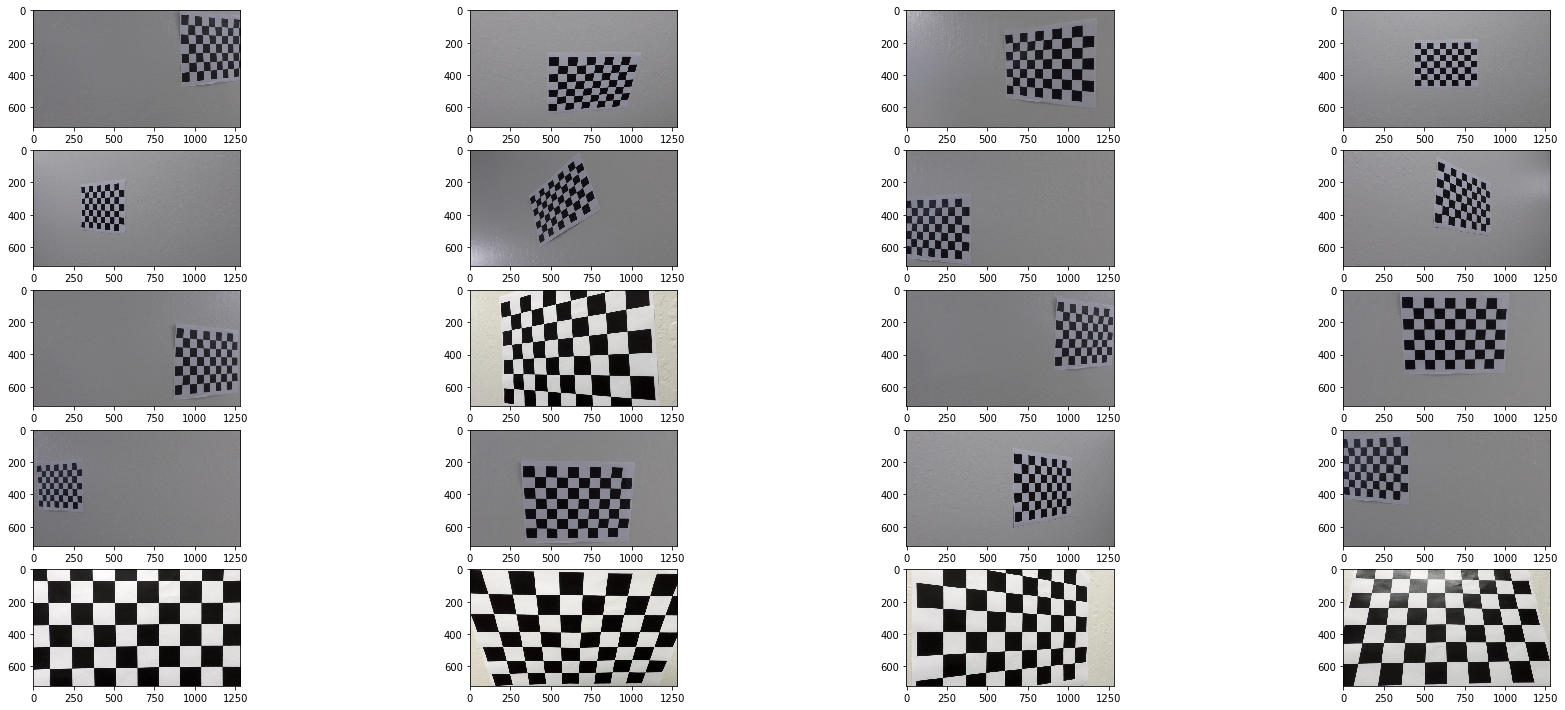

In [86]:
# Display a list of undistorted images
cimages = glob.glob('calibration_wide/*_undistorted.jpg')
undist_images = [mpimg.imread(file) for file in cimages]
display(undist_images,'rgb')

## Applying to raw images

In [87]:
images = glob.glob("test_images/*.jpg")
undistort_list = undistort_images(images, mtx, dist, dir_name = 'test_images_undistort/', todo = 'save')

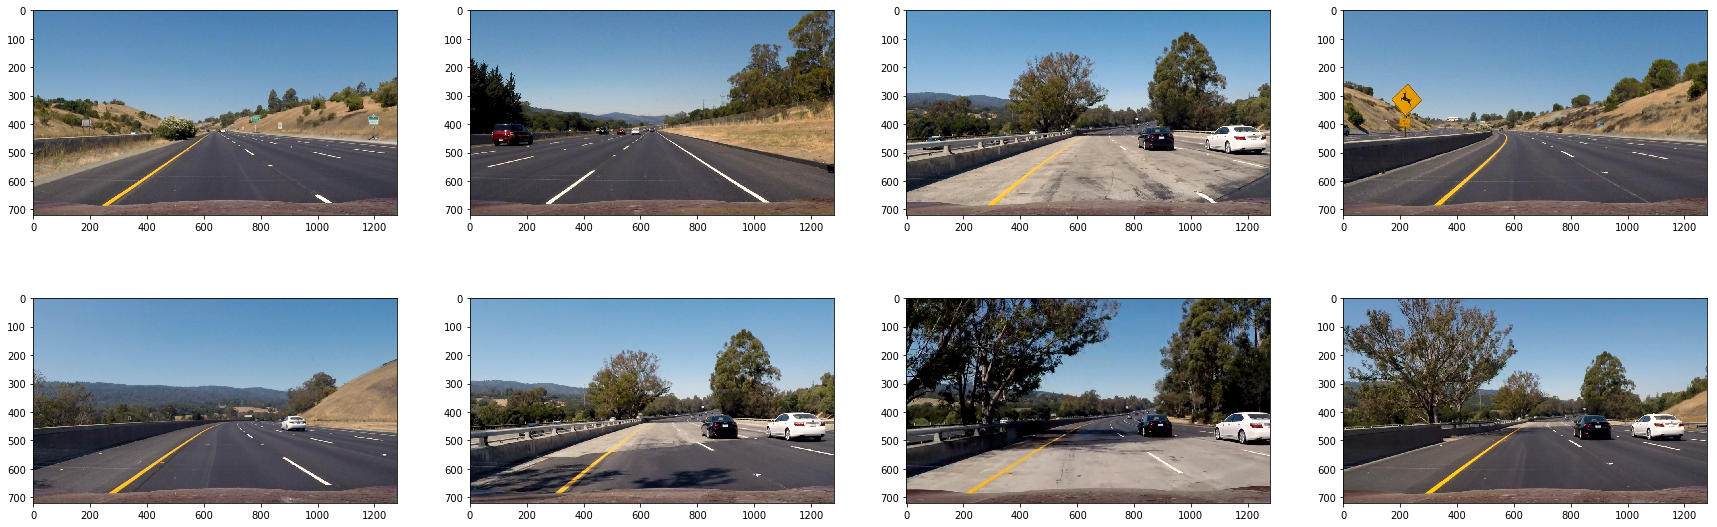

In [88]:
testoriginal = glob.glob("test_images/*.jpg")
testoriginal.sort()
test_images =  [mpimg.imread(file) for file in testoriginal]
display(test_images,'rgb')

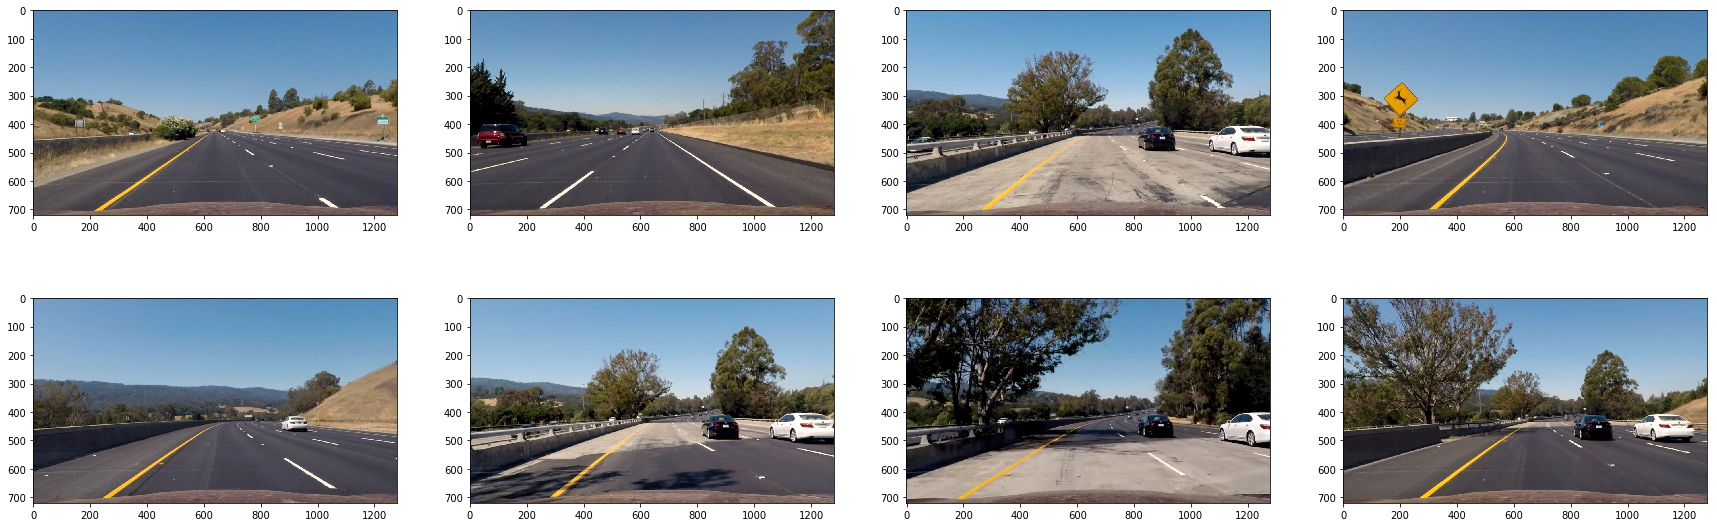

In [89]:
testundistorted = glob.glob("test_images_undistort/*.jpg")
testundistorted.sort()
test_images =  [mpimg.imread(file) for file in testundistorted]
display(test_images,'rgb')

## Applying color transforms, gradient thresholds to extract lanes

In [90]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gimg = (cv2.cvtColor(img, cv2.COLOR_RGB2LAB))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_img = (cv2.Sobel(gimg, cv2.CV_64F,1,0) if orient=='x' else cv2.Sobel(gimg, cv2.CV_64F,0,1))
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask_sobel = np.zeros_like(scaled_sobel)
    mask_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return mask_sobel

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2LAB))[:,:,0]
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    s_ss = ((sobel_x ** 2) + (sobel_y **2)) # reduced time of execution than np.square() 
    mag_sobel = np.sqrt(s_ss)
    scale_factor = np.max(mag_sobel)/255
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    bin_img = np.uint8(mag_sobel/scale_factor)
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(bin_img)
    sbinary[(bin_img >= mag_thresh[0]) & (bin_img <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2LAB))[:,:,0]
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobel_x)
    abs_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    bin_img = np.arctan2(abs_y,abs_x)
    # 5) Create a binary mask where direction thresholds are met
    bin_out = np.zeros_like(bin_img)
    bin_out[(bin_img >= thresh[0]) & (bin_img <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(bin_out) # Remove this line
    return binary_output



In [91]:
def compute_hls_white_yellow_binary(rgb_img,
              H_yell_min=15 , H_yell_max=35,
              L_yell_min=30, L_yell_max=204, S_yell_min=115, S_yell_max=255, H_whit_min=0 , H_whit_max=255,
              L_whit_min=200, L_whit_max=255, S_whit_min=0, S_whit_max=255):
    """
    Returns a binary thresholded image containing the white and yellow 
    contents of the image which is mostly targeted for the lanes
    """
    hls_img = rgb_img
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= H_yell_min) & (hls_img[:,:,0] <= H_yell_max))
                 & ((hls_img[:,:,1] >= L_yell_min) & (hls_img[:,:,1] <= L_yell_max))
                 & ((hls_img[:,:,2] >= S_yell_min) & (hls_img[:,:,2] <= S_yell_max))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= H_whit_min) & (hls_img[:,:,0] <= H_whit_max))
                 & ((hls_img[:,:,1] >= L_whit_min) & (hls_img[:,:,1] <= L_whit_max))
                 & ((hls_img[:,:,2] >= S_whit_min) & (hls_img[:,:,2] <= S_whit_max))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

In [92]:
test_images =  [mpimg.imread(file) for file in testundistorted]
test_images_hls = [convert_hls(img) for img in test_images]
@interact
def hls_tweak(images = fixed(test_images_hls), i:(0, len(test_images_hls)-1)=1,
              H_whit_min:(0,255)=0 , H_whit_max:(0,225)=255,
              L_whit_min:(0,255)=200, L_whit_max:(0,255)=255, S_whit_min:(0,255)=0, S_whit_max:(0,255)=255,
              H_yell_min:(0,255)=15 , H_yell_max:(0,225)=50,
              L_yell_min:(0,255)=40, L_yell_max:(0,255)=255, S_yell_min:(0,255)=110, S_yell_max:(0,255)=255):
    img = test_images_hls[i]
    
    img = compute_hls_white_yellow_binary(img,  H_yell_min , H_yell_max ,
              L_yell_min, L_yell_max, S_yell_min, S_yell_max, H_whit_min , H_whit_max,
              L_whit_min, L_whit_max, S_whit_min, S_whit_max)
    
    return display_image(img)

interactive(children=(IntSlider(value=1, description='i', max=7), IntSlider(value=0, description='H_whit_min', max=255), IntSlider(value=225, description='H_whit_max', max=225), IntSlider(value=200, description='L_whit_min', max=255), IntSlider(value=255, description='L_whit_max', max=255), IntSlider(value=0, description='S_whit_min', max=255), IntSlider(value=255, description='S_whit_max', max=255), IntSlider(value=15, description='H_yell_min', max=255), IntSlider(value=50, description='H_yell_max', max=225), IntSlider(value=40, description='L_yell_min', max=255), IntSlider(value=255, description='L_yell_max', max=255), IntSlider(value=110, description='S_yell_min', max=255), IntSlider(value=255, description='S_yell_max', max=255), Output()), _dom_classes=('widget-interact',))

In [93]:
def pipeline(imag, sx_thresh=(20, 120), mag_thresh=(80, 200), dir_thresh=(np.pi/4, np.pi/2)):
    
    img = np.copy(imag)

    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
     
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=sx_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    s_binary = compute_hls_white_yellow_binary(hls,H_yell_min=15 , H_yell_max=35,
              L_yell_min=30, L_yell_max=204, S_yell_min=115, S_yell_max=255, H_whit_min=0 , H_whit_max=255,
              L_whit_min=200, L_whit_max=255, S_whit_min=0, S_whit_max=255)


    combined_gradients = np.zeros_like(dir_binary)
    combined_gradients[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1) & (grady == 1))] = 1
    
    combined = np.zeros_like(s_binary)
    combined[(combined_gradients == 1)  | (s_binary ==1 )] = 1 
  
    combined_thresholds.append(combined)
    
    # Stack each channel; Now stacking sobel X grad and Saturation binaries
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255
    
    return combined 



In [94]:
@interact
def combined_threshold_image(images=fixed(test_images), i:(0,len(test_images)-1)=1, 
                    sobel_kernel:(3,21,2)=3,
                    s_thresh_min:(0,255)=20, s_thresh_max:(0,255)=120,
                    mag_thresh_min:(0,255)=70, mag_thresh_max:(0,255)=150,
                    dir_thresh_min:(0.,np.pi/4)=0.7, dir_thresh_max:(0,np.pi/2)=0.9):
  
    img=images[i]
    dir_binary=pipeline(img, sx_thresh=(s_thresh_min, s_thresh_max), 
                        mag_thresh=(mag_thresh_min, mag_thresh_max), dir_thresh=(dir_thresh_min, dir_thresh_max))
    return display_image(dir_binary,"gray")

interactive(children=(IntSlider(value=1, description='i', max=7), IntSlider(value=3, description='sobel_kernel', max=21, min=3, step=2), IntSlider(value=20, description='s_thresh_min', max=255), IntSlider(value=120, description='s_thresh_max', max=255), IntSlider(value=70, description='mag_thresh_min', max=255), IntSlider(value=150, description='mag_thresh_max', max=255), FloatSlider(value=0.7, description='dir_thresh_min', max=0.7853981633974483), FloatSlider(value=0.9, description='dir_thresh_max', max=1.5707963267948966), Output()), _dom_classes=('widget-interact',))

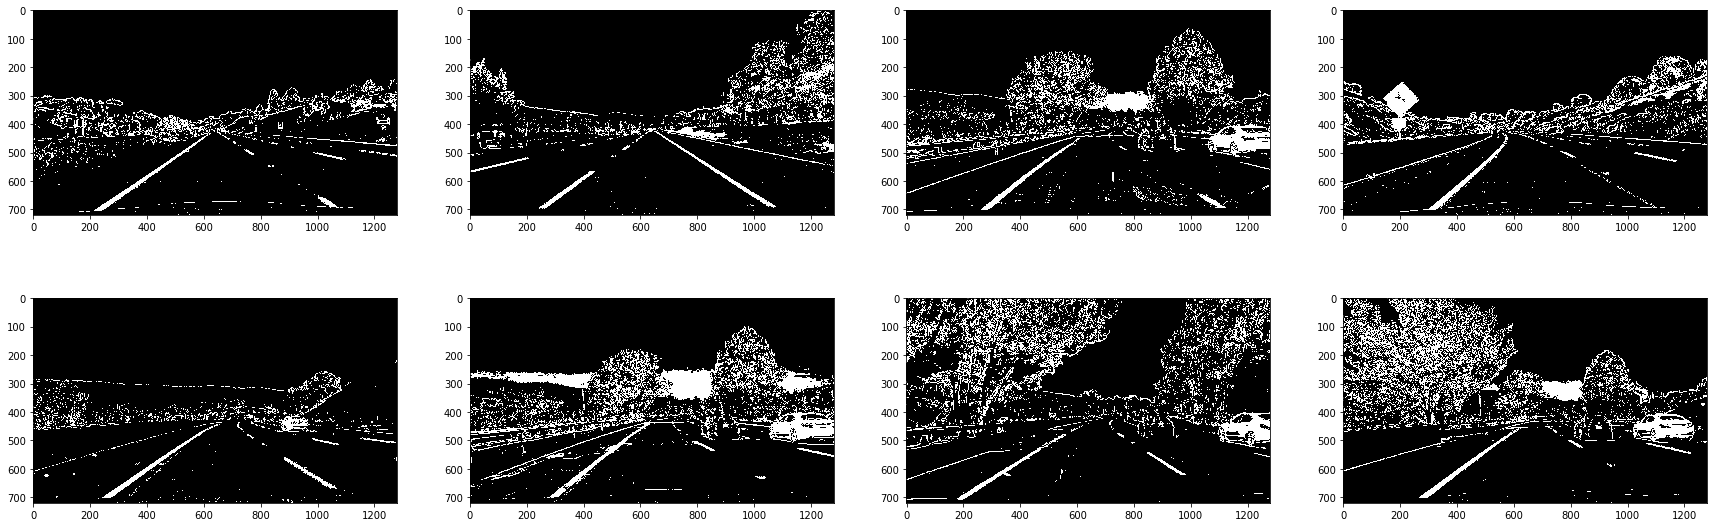

In [95]:
combined_thresholds = []

result = [pipeline(image) for image in test_images]
display(result)

## Perspective Transform

### Try out :

719 1279


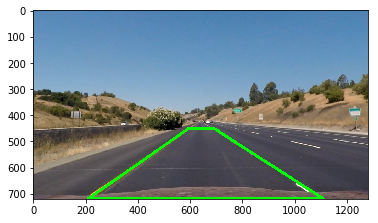

In [96]:
sample_image = np.copy(test_images[0]) # basically it references hence np.copy() is used

# Perspective transform warps the provided image into a birds eye view; needed src and dest points
(height_y, width_x) = (sample_image.shape[0]-1, sample_image.shape[1]-1)
pts = np.array([[210,height_y],[595,450],[690,450], [1110, height_y]]) 
cv2.polylines(sample_image,[pts],True,(0,255,0), 10)
plt.imshow(sample_image)
print(height_y, width_x)

In [97]:
def perspective_transform(img, src, dst):   
    """
    Returns a perspective transform
    """
    return cv2.warpPerspective(img, (cv2.getPerspectiveTransform(src, dst)),
                               (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

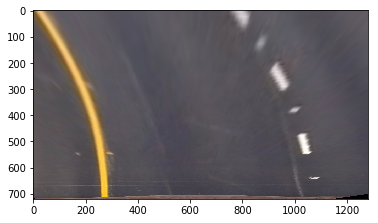

In [98]:
warped_undist_images = list()
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, height_y], [200, 0], [1000, 0], [1000, height_y]], np.float32)
warped_test_image = perspective_transform(test_images[3],src_pts,dst_pts)
plt.imshow(warped_test_image)

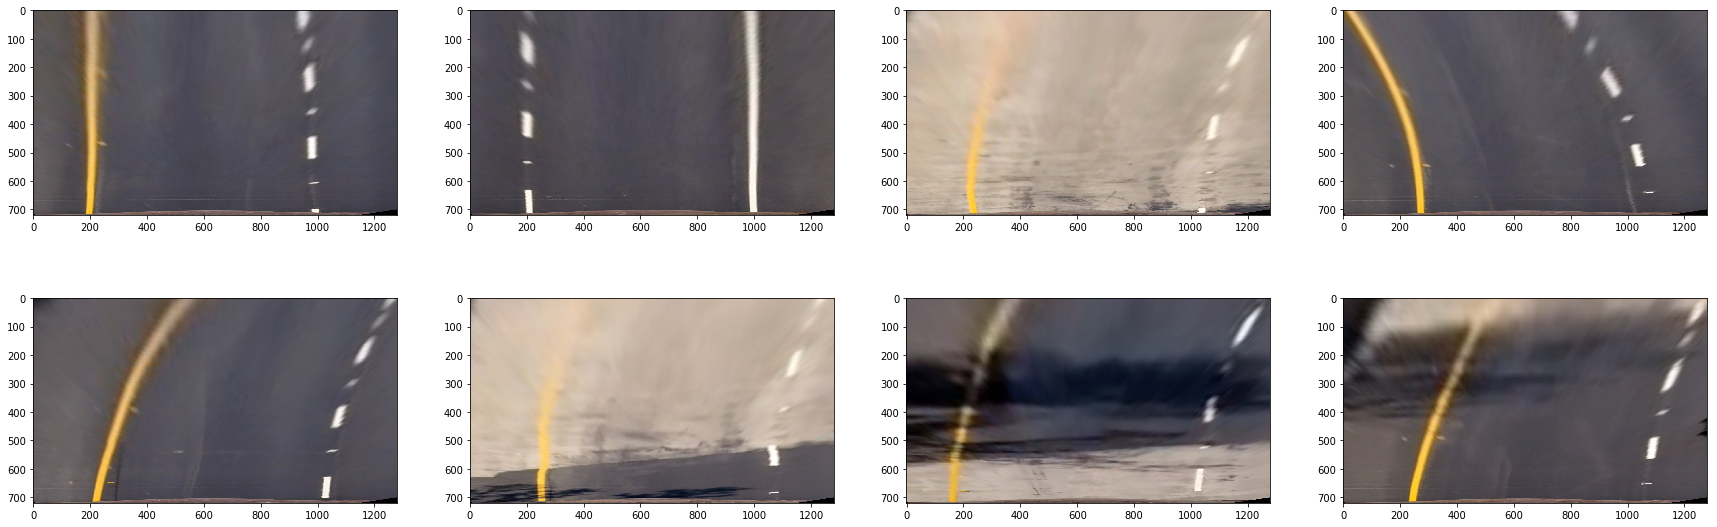

In [99]:
warped_undist_images = [perspective_transform(mpimg.imread(file),src_pts,dst_pts) for file in testundistorted]
display(warped_undist_images)

### Warped image straight lines sanity check

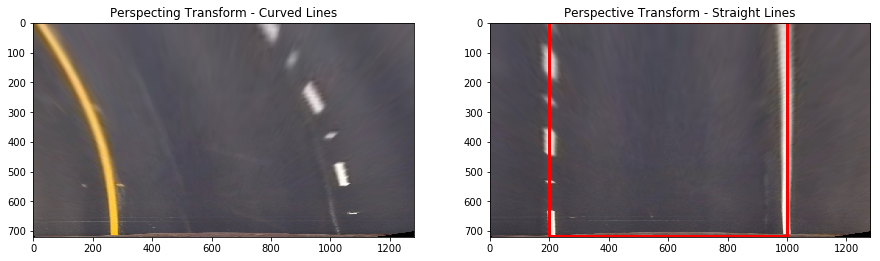

In [100]:
sanity_undist_test_image =  np.copy(test_images[1])
warped_test_image_straight = perspective_transform(sanity_undist_test_image,src_pts,dst_pts)
dst = dst_pts.astype(np.int32)
cv2.polylines(warped_test_image_straight,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(warped_test_image)
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(warped_test_image_straight)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()


## Applying all the preprocessing on the warped images to detect lanes

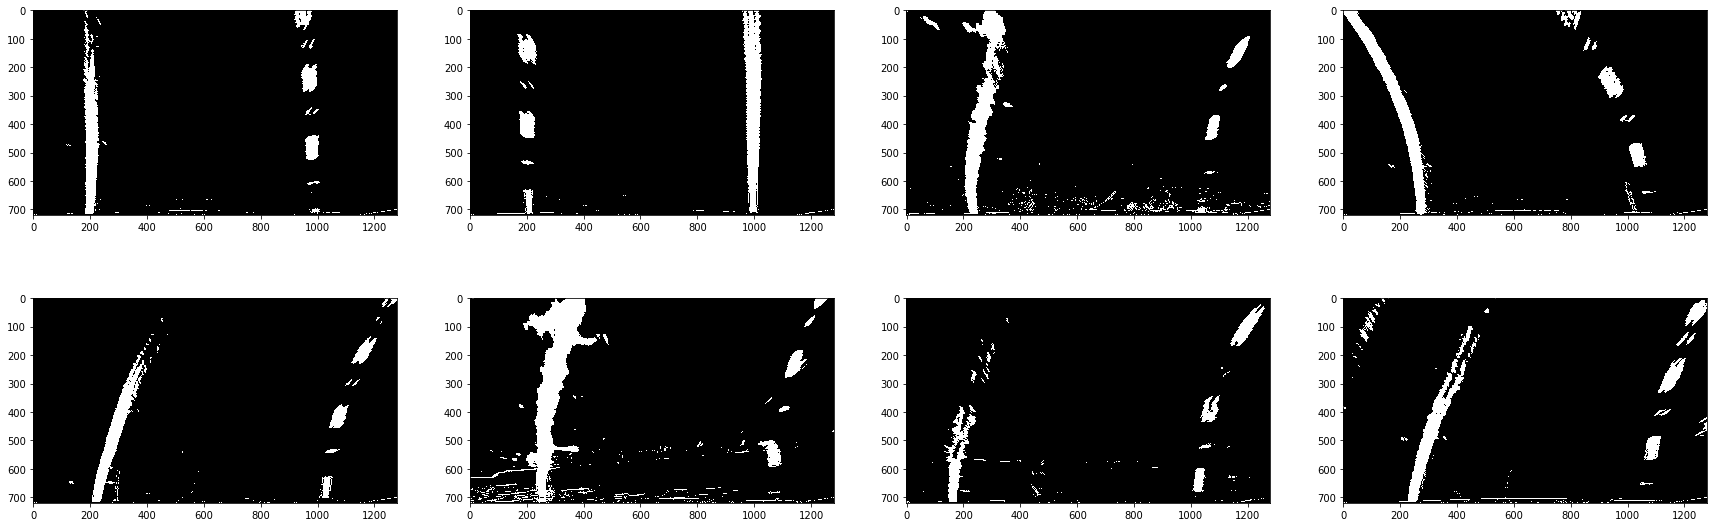

In [101]:
combined_thresholds.clear()
result = [pipeline(image) for image in warped_undist_images]
display(combined_thresholds)

### Finding the lane peaks by histogram method

(720, 1280)


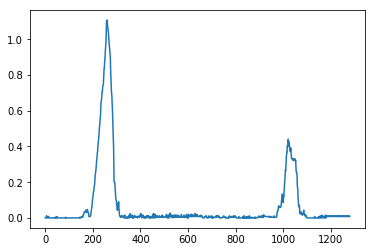

In [102]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = combined_thresholds[3]/255
print(img.shape)

def hist(img):
  # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

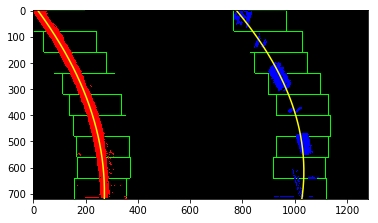

In [103]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin =  100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height # 720 - 80 -- 640
        win_y_high = binary_warped.shape[0] - window*window_height    # 720 - 0 -- 720
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =  leftx_current- (margin)  # Update this  # base peakLeft - 100 
        win_xleft_high = leftx_current+ (margin)  # Update this
        win_xright_low = rightx_current- (margin)  # Update this
        win_xright_high = rightx_current+ (margin) 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) # imp_ for next image
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) # imp_for next frame

       
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(combined_thresholds[3])

plt.imshow(out_img)

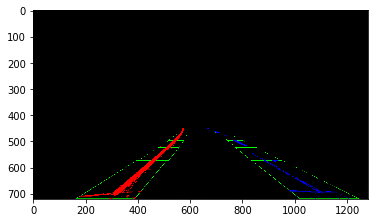

In [104]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, height_y], [200, 0], [1000, 0], [1000, height_y]], np.float32)
warped_test_image = perspective_transform(out_img ,dst_pts,src_pts)
plt.imshow(warped_test_image)

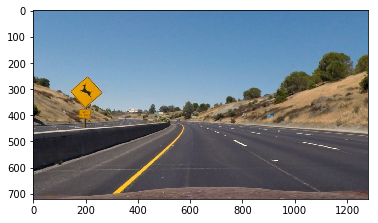

In [105]:
or_img  =   np.copy(test_images[3])
plt.imshow(or_img)

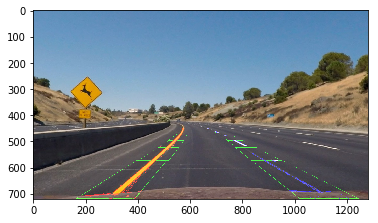

In [106]:
or_img = or_img | warped_test_image
plt.imshow(or_img)

In [107]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [108]:
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 +  (2*left_fit[0]*y_eval+ left_fit[1])**2)**(3/2)) / np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 +  (2*right_fit[0]*y_eval+ right_fit[1])**2)**(3/2)) / np.absolute(2*right_fit[0])   ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [109]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad
                                  